In [1]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from nltk import collocations
from nltk import pos_tag as pos
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

## Importing saved articles - American Women Chief Executives

In [7]:
# Import all CSV files from all Wiki articles and save them to one list
files = glob.glob("articles/*.csv")

all_articles = []

for file in files:
    read_handle = open(file, "r")
    text = list(csv.reader(read_handle, delimiter=","))        
    for article in text[1:]:
        all_articles.append(article[1])     

# How many articles has been read
print('Number of articles:', len(all_articles))

articles_df = pd.DataFrame(all_articles, columns = ['article'])

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

Number of articles: 488
After de-duplication: 488


## Preprocessing and tokenisation

In [14]:
all_tokens = []

# import stopwords
stop_words = stopwords.words('english') + ['co', 'u', 'th']
wnl = WordNetLemmatizer()

for article in all_articles:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in stop_words:  # to remove stopwords
            Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
            doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 488 

-No-   --Tokens--
  1       321
  2       733
  3       163
  4       237
  5       276
  6       161
  7       545
  8       172
  9       543
 10      1167
 11       324
 12       395
 13       384
 14        95
 15       298


## Dictionary and corpus

In [15]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 15, no_above = 0.7)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

Dictionary length: 1580
Top 20 tokens by frequency

1. president - 1271
2. new - 1225
3. business - 1113
4. board - 1048
5. school - 1040
6. first - 964
7. executive - 778
8. state - 775
9. director - 747
10. one - 747
11. award - 736
12. york - 683
13. time - 673
14. served - 651
15. national - 619
16. member - 619
17. named - 547
18. became - 543
19. chief - 478
20. college - 473

Corpus created. 
Corpus length: 488


In [16]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/AWCEO_frequency_top_250.csv', index = False, header = True)

## Bigrams

In [17]:
# Bigrams by frequency
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(10)

Number of unique bigrams in the articles: 144278


,bigram,count
0,"(new, york)",677
1,"(united, state)",361
2,"(vice, president)",268
3,"(board, director)",250
4,"(chief, executive)",221
5,"(high, school)",190
6,"(executive, officer)",177
7,"(president, ceo)",173
8,"(powerful, woman)",168
9,"(york, city)",166


In [36]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/AWCEO_bigrams_100.csv', index = False, header = True)

In [20]:
# Bigrams by PMI score
bigram_measures = collocations.BigramAssocMeasures()

finder = collocations.BigramCollocationFinder.from_documents(all_tokens)

# Filter only those that occur at least N times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

# Create a dataframe with bigram PMI scores -  Pointwise Mutual Information
# This measures how much more likely the words co-occur than if they were independent. 
# The metric is sensitive to rare combination of words, so it is used with an occurrence 
# frequency filter to ensure phrase relevance.
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
print('Number of bigrams:',len(bigram_pmi.index))
bigram_pmi.head(10)

Number of bigrams: 271


,bigram,pmi
0,"(hong, kong)",12.832802
1,"(simon, schuster)",12.665578
2,"(planned, parenthood)",12.543296
3,"(cum, laude)",12.095837
4,"(magna, cum)",12.095837
5,"(leon, guerrero)",11.725410
6,"(silicon, valley)",11.562713
7,"(covid, pandemic)",11.436096
8,"(joe, biden)",11.395890
9,"(chamber, commerce)",11.324655


In [21]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = pos(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [26]:
# Filter bigrams for noun-type structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]
print('Number of filtered bigrams:',len(filtered_bigram.index))
filtered_bigram.head()

Number of filtered bigrams: 170


,bigram,pmi
0,"(hong, kong)",12.832802
1,"(simon, schuster)",12.665578
2,"(planned, parenthood)",12.543296
4,"(magna, cum)",12.095837
5,"(leon, guerrero)",11.725410


In [34]:
# Filter bigrams for noun-type structures
filtered_bigram_frq = bigram_df[bigram_df.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              , axis = 1)]
print('Number of filtered bigrams:',len(filtered_bigram_frq.index))
filtered_bigram_frq.head()

Number of filtered bigrams: 94


,bigram,count
0,"(new, york)",677
1,"(united, state)",361
2,"(vice, president)",268
3,"(board, director)",250
4,"(chief, executive)",221


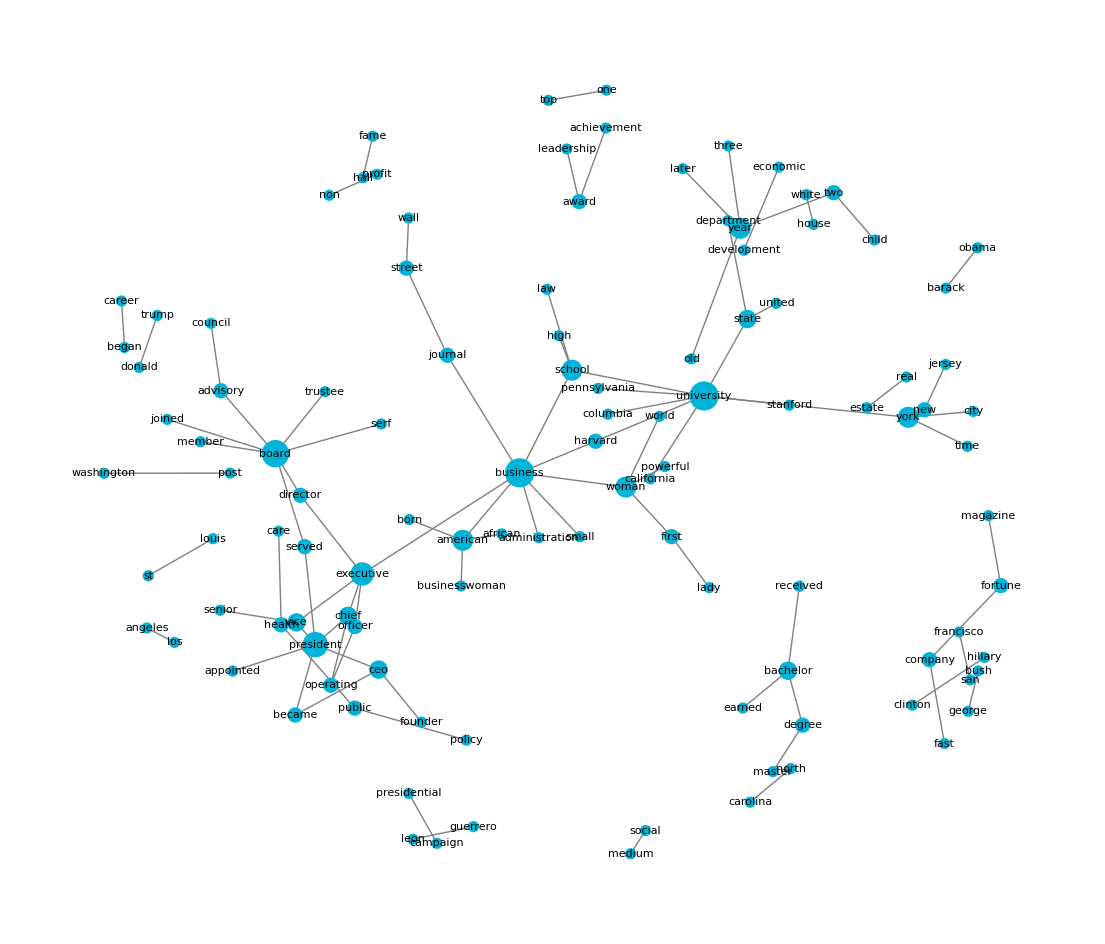

In [41]:
# Bigram visualisation - Noun only based on frequency
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = filtered_bigram_frq.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size = 8,
        width = 1,
        edge_color = 'grey',
        node_color = '#00b4d9',
        with_labels = True, 
        nodelist = list(d.keys()), 
        node_size = [v * 50 for v in d.values()])
plt.show()

In [12]:
# Joining bigrams
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
bigrams[:10]

['hewlett packard',
 'alma mater',
 'desmond hellmann',
 'hong kong',
 'ben ishay',
 'simon schuster',
 'von tobel',
 'planned parenthood',
 'phi beta',
 'douglas elliman']

### Trigrams

In [42]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_) 
    
print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 398
Number of unique trigrams: 48

Top 20 trigrams by frequency

1. new_york_city - 166
2. chief_executive_officer - 144
3. new_york_time - 93
4. executive_vice_president - 69
5. senior_vice_president - 57
6. chief_operating_officer - 48
7. wall_street_journal - 47
8. president_chief_executive - 32
9. president_barack_obama - 30
10. world_economic_forum - 29
11. earned_bachelor_degree - 28
12. powerful_woman_world - 27
13. woman_hall_fame - 27
14. non_profit_organization - 25
15. university_southern_california - 24
16. received_bachelor_degree - 22
17. boy_girl_club - 21
18. united_state_senate - 20
19. president_george_bush - 19
20. lifetime_achievement_award - 19


In [46]:
# Writing top 50 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:50])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/AWCEO_trigrams_50.csv', index = False, header = True)

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

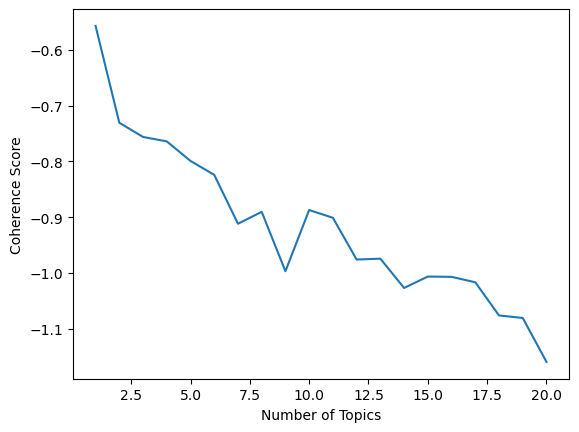

In [60]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                             iterations = 10, num_topics = i, 
                             workers = 4, passes = 10, 
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, 
                             iterations=10, num_topics=i, 
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA Model

In [61]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                         iterations = 10, num_topics = 9, 
                         workers = 4, passes = 10, 
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')  
cm_score = cm.get_coherence()

print('LDA model coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

LDA model coherence score: -0.9813224135962622

Topic: 0 
Words: 0.019*"new" + 0.014*"york" + 0.011*"time" + 0.010*"award" + 0.009*"medium" + 0.008*"magazine" + 0.008*"book" + 0.008*"first" + 0.008*"one" + 0.007*"business"

Topic: 1 
Words: 0.012*"business" + 0.011*"first" + 0.011*"new" + 0.010*"president" + 0.008*"one" + 0.008*"york" + 0.008*"school" + 0.007*"million" + 0.006*"child" + 0.006*"time"

Topic: 2 
Words: 0.014*"state" + 0.013*"president" + 0.012*"election" + 0.011*"campaign" + 0.010*"school" + 0.009*"district" + 0.009*"new" + 0.008*"republican" + 0.008*"vote" + 0.007*"served"

Topic: 3 
Words: 0.011*"new" + 0.008*"first" + 0.007*"one" + 0.006*"girl" + 0.006*"series" + 0.006*"released" + 0.005*"book" + 0.005*"film" + 0.005*"business" + 0.005*"child"

Topic: 4 
Words: 0.018*"president" + 0.016*"board" + 0.011*"state" + 0.011*"national" + 0.010*"foundation" + 0.010*"served" + 0.010*"united" + 0.009*"member" + 0.009*"executive" + 0.008*"international"

Topic: 5 
Words: 0.021*"

## LDA Visualisation

In [62]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.056301 -0.001267       1        1  17.112803
6     -0.066438  0.067784       2        1  14.997999
0      0.098055  0.038435       3        1  12.666748
7     -0.004119  0.054431       4        1  10.808460
2     -0.052353 -0.095918       5        1   9.755556
3      0.081179 -0.034571       6        1   9.712218
1      0.046354 -0.018027       7        1   9.303191
4     -0.047555  0.009832       8        1   8.433199
8      0.001179 -0.020698       9        1   7.209825, topic_info=         Term         Freq        Total Category  logprob  loglift
469      bush   251.000000   251.000000  Default  30.0000  30.0000
416  election   176.000000   176.000000  Default  29.0000  29.0000
148     board  1073.000000  1073.000000  Default  28.0000  28.0000
185  district   126.000000   126.000000  Default  27.0000  27.0000
526      vote   111.000000   111.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
271       new    41.234287  1211.763085   Topic9  -5.3852  -0.7508
482    family    32.690959   340.784374   Topic9  -5.6174   0.2856
96    program    33.425292   438.799015   Topic9  -5.5952   0.0550
436    member    34.029229   624.671383   Topic9  -5.5772  -0.2803
103    school    34.949247  1040.196227   Topic9  -5.5506  -0.7635

[597 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1232      3  0.710885   abc
1232      5  0.035544   abc
1232      6  0.106633   abc
1232      7  0.071088   abc
1232      9  0.035544   abc
...     ...       ...   ...
349       5  0.063651  york
349       6  0.074013  york
349       7  0.133224  york
349       8  0.072533  york
349       9  0.032566  york

[3498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 8, 3, 4, 2, 5, 9])

In [72]:
# Table representation of topics
# Update number of topics as per LDA model above
no_of_topics = 9

topic_data =  pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8 # Adjust this accordingly based on tuning above
for i in range(1,no_of_topics): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,board,business,president,executive,chief,director,named,officer,served,powerful
Topic 2,school,science,art,new,health,education,research,college,national,president
Topic 3,new,york,time,award,medium,magazine,book,music,film,one
Topic 4,bush,business,first,award,development,economic,one,investment,entrepreneur,research
Topic 5,election,state,campaign,district,vote,republican,president,school,county,governor
Topic 6,new,released,girl,series,first,film,one,black,show,game
Topic 7,business,first,new,frank,president,one,york,million,store,school
Topic 8,president,board,national,foundation,state,united,served,member,international,executive


## Testing model

In [98]:
# probability of a word belonging to a topic
test_words = ['european', 'woman', 'served', 'elected']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: european  - belongs to:
Topic: 0 
Probability: 0.06170090660452843

Topic: 8 
Probability: 0.012142736464738846


Word: woman  - belongs to:
Topic: 1 
Probability: 0.010541661642491817

Topic: 3 
Probability: 0.014930302277207375

Topic: 5 
Probability: 0.01693888194859028


Word: served  - belongs to:
Topic: 1 
Probability: 0.014407980255782604

Topic: 7 
Probability: 0.011427057906985283


Word: elected  - belongs to:
Topic: 1 
Probability: 0.016755618155002594

Topic: 2 
Probability: 0.026537824422121048

Topic: 6 
Probability: 0.012585447169840336

Topic: 7 
Probability: 0.01687142811715603



In [50]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]  
# This shows how the query relates to the topics
vec_lda

[(0, 0.03490614),
 (1, 0.034060966),
 (2, 0.034278072),
 (3, 0.86267275),
 (4, 0.03408209)]

## Other

In [73]:
# Seemingly better model - needs installation
# https://radimrehurek.com/gensim_3.8.3/models/wrappers/ldamallet.html
# based on https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

from gensim.models.wrappers import LdaMallet

ModuleNotFoundError: No module named 'gensim.models.wrappers'